<a href="https://colab.research.google.com/github/danyadanish/PredictionUsingSparkML/blob/main/predictionSparkML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports



In [ ]:
# Install PySpark and MongoDB Connector
!apt install openjdk-11-jdk -y
!pip install pyspark
!wget https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/3.0.1/mongo-spark-connector_2.12-3.0.1.jar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jre
  x11-utils
Suggested packages:
  libxt-doc openjdk-11-demo openjdk-11-source visualvm mesa-utils
The following NEW packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libxt-dev libxtst6 libxxf86dga1 openjdk-11-jdk
  openjdk-11-jre x11-utils
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 6,920 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1,041 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-extra all 2.37-2build1 [2,041 kB]
Get:3 http://archive.ubuntu.com/ubuntu jam

In [ ]:
import os
from pyspark.sql import SparkSession

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

spark = SparkSession.builder \
    .appName("NYC Yellow Taxi Trip Analysis") \
    .config("spark.jars", "mongo-spark-connector_2.12-3.0.1.jar") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/taxi_db.trips") \
    .getOrCreate()


In [ ]:
trip_df = spark.read.option("header", True).option("inferSchema", True).csv("/content/taxi_trip_data.csv")
zone_df = spark.read.option("header", True).option("inferSchema", True).csv("/content/taxi_zone_geo.csv")


In [ ]:
# Show schema and some rows for trip_df
print("Trip DataFrame Schema:")
trip_df.printSchema()
print("Trip DataFrame sample:")
trip_df.show(5)

Trip DataFrame Schema:
root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)

Trip DataFrame sample:
+---------+----------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor

In [ ]:
# Show schema and some rows for zone_df
print("\nZone DataFrame Schema:")
zone_df.printSchema()
print("Zone DataFrame sample:")
zone_df.show(5)



Zone DataFrame Schema:
root
 |-- zone_id: integer (nullable = true)
 |-- zone_name: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zone_geom: string (nullable = true)

Zone DataFrame sample:
+-------+--------------------+-------+--------------------+
|zone_id|           zone_name|borough|           zone_geom|
+-------+--------------------+-------+--------------------+
|      1|      Newark Airport|    EWR|POLYGON((-74.1856...|
|      3|Allerton/Pelham G...|  Bronx|POLYGON((-73.8485...|
|     18|        Bedford Park|  Bronx|POLYGON((-73.8844...|
|     20|             Belmont|  Bronx|POLYGON((-73.8839...|
|     31|          Bronx Park|  Bronx|POLYGON((-73.8710...|
+-------+--------------------+-------+--------------------+
only showing top 5 rows



# Data Exploration and Initial Analysis

In [ ]:
# Basic analysis on trip_df
print("\nBasic statistics for Trip DataFrame:")
trip_df.describe().show()



Basic statistics for Trip DataFrame:
+-------+------------------+---------------+----------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+
|summary|         vendor_id|pickup_datetime|dropoff_datetime|   passenger_count|    trip_distance|         rate_code|store_and_fwd_flag|       payment_type|       fare_amount|              extra|            mta_tax|        tip_amount|      tolls_amount|       imp_surcharge|pickup_location_id|dropoff_location_id|
+-------+------------------+---------------+----------------+------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+
|  count|           

In [ ]:
# Basic analysis on zone_df
print("\nBasic statistics for Zone DataFrame:")
zone_df.describe().show()


Basic statistics for Zone DataFrame:
+-------+------------------+--------------------+-------------+--------------------+
|summary|           zone_id|           zone_name|      borough|           zone_geom|
+-------+------------------+--------------------+-------------+--------------------+
|  count|               263|                 263|          263|                 263|
|   mean|131.98479087452472|                NULL|         NULL|                NULL|
| stddev| 76.07378748192713|                NULL|         NULL|                NULL|
|    min|                 1|Allerton/Pelham G...|        Bronx|MULTIPOLYGON(((-7...|
|    max|               263|      Yorkville West|Staten Island|POLYGON((-74.2105...|
+-------+------------------+--------------------+-------------+--------------------+



In [ ]:
# Count the number of trips
trip_count = trip_df.count()
print(f"\nTotal number of trips: {trip_count}")


Total number of trips: 70655


In [ ]:
# Find the average trip distance
from pyspark.sql.functions import avg
average_distance = trip_df.agg(avg("trip_distance")).collect()[0][0]
print(f"Average trip distance: {average_distance:.2f}")


Average trip distance: 2.92


In [ ]:
# Count the number of zones
zone_count = zone_df.count()
print(f"\nTotal number of zones: {zone_count}")


Total number of zones: 263


In [ ]:
# Find the number of unique boroughs
from pyspark.sql.functions import countDistinct
unique_boroughs = zone_df.agg(countDistinct("borough")).collect()[0][0]
print(f"Number of unique boroughs: {unique_boroughs}")


Number of unique boroughs: 6


In [ ]:

from pyspark.sql.functions import col, sum, when, count, lit

def analyze_dataframe(df, df_name):
    print(f"\n--- Analysis for DataFrame: {df_name} ---")

    # 1. Columns with missing values (including zeros as potential missing)
    print("Missing Values (Nulls or Zero-equivalents):")
    missing_counts = df.select([sum(when((col(c).isNull()) | (col(c) == 0), lit(1)).otherwise(lit(0))).alias(c) for c in df.columns])
    missing_counts.show()

    # 2. Value distributions (example for key columns)
    print("\nValue Distributions:")
    if 'payment_type' in df.columns:
        print("\nPayment Type Distribution:")
        df.groupBy("payment_type").count().show()
    if 'passenger_count' in df.columns:
        print("\nPassenger Count Distribution:")
        df.groupBy("passenger_count").count().show()
    if 'trip_distance' in df.columns:
        print("\nTrip Distance Summary Statistics:")
        df.select("trip_distance").describe().show()
    if 'total_amount' in df.columns:
        print("\nTotal Amount Summary Statistics:")
        df.select("total_amount").describe().show()
    if 'pickup_borough' in df.columns:
        print("\nPickup Borough Distribution:")
        df.groupBy("pickup_borough").count().show()
    if 'zone' in df.columns:
         print("\nZone Distribution (top 20):")
         df.groupBy("zone").count().orderBy(col("count").desc()).show(20)


    # 3. Observations about outliers or suspicious values
    # This requires looking at the describe() output and distributions
    print("\nObservations about Outliers or Suspicious Values:")
    print("Review the 'describe()' outputs for columns like 'trip_distance', 'fare_amount', 'total_amount'.")
    print("High maximum values might indicate outliers.")
    print("Zero counts for columns like 'passenger_count' or 'trip_distance' should be investigated if not expected.")
    if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
        print("Check for cases where dropoff time is before pickup time (requires calculating trip duration).")
    if 'total_amount' in df.columns and 'fare_amount' in df.columns and 'tip_amount' in df.columns:
        print("Check if total_amount is the sum of fare_amount, tip_amount, and other charges (taxes, tolls, etc.).")


    # 4. Other metadata
    print("\nOther Metadata:")
    print(f"Number of rows: {df.count()}")
    print(f"Number of columns: {len(df.columns)}")
    print("Schema:")
    df.printSchema()

In [ ]:
analyze_dataframe(trip_df, "Trip DataFrame")


--- Analysis for DataFrame: Trip DataFrame ---
Missing Values (Nulls or Zero-equivalents):
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|
+---------+---------------+----------------+---------------+-------------+---------+------------------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+
|        0|              0|               0|            626|          475|        0|                 0|           0|         15|37724|    293|     24058|       66762|           25|                 0|                  0|
+---------+---------------+-

In [ ]:
analyze_dataframe(zone_df, "Zone DataFrame")


--- Analysis for DataFrame: Zone DataFrame ---
Missing Values (Nulls or Zero-equivalents):
+-------+---------+-------+---------+
|zone_id|zone_name|borough|zone_geom|
+-------+---------+-------+---------+
|      0|        0|      0|        0|
+-------+---------+-------+---------+


Value Distributions:

Observations about Outliers or Suspicious Values:
Review the 'describe()' outputs for columns like 'trip_distance', 'fare_amount', 'total_amount'.
High maximum values might indicate outliers.
Zero counts for columns like 'passenger_count' or 'trip_distance' should be investigated if not expected.

Other Metadata:
Number of rows: 263
Number of columns: 4
Schema:
root
 |-- zone_id: integer (nullable = true)
 |-- zone_name: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- zone_geom: string (nullable = true)



# Data Cleaning

## Removing Complete Nulls and Duplicates

In [ ]:
from pyspark.sql.functions import (
    col, unix_timestamp, round, when, isnan, lit, abs
)

# Load the CSVs (using the existing dataframes from previous cells)
trip_df_raw = trip_df # Keep a raw copy if needed later, though not strictly necessary for the fix

# Drop completely null rows
trip_df = trip_df_raw.dropna(how="all")

# Drop duplicates
trip_df = trip_df.dropDuplicates()

# Drop columns that don’t contribute meaningfully
useless_cols = ["medallion", "hack_license", "store_and_fwd_flag"]
cols_to_drop = [c for c in useless_cols if c in trip_df.columns]
trip_df = trip_df.drop(*cols_to_drop)

## Adding New Columns

In [ ]:

# Convert pickup/dropoff datetime to timestamp and compute trip duration
if "pickup_datetime" in trip_df.columns and "dropoff_datetime" in trip_df.columns:
    # Attempt to parse based on observed format (M/d/yyyy H:mm)
    trip_df = trip_df.withColumn("pickup_ts", unix_timestamp(col("pickup_datetime"), "M/d/yyyy H:mm"))
    trip_df = trip_df.withColumn("dropoff_ts", unix_timestamp(col("dropoff_datetime"), "M/d/yyyy H:mm"))

    # Trip duration in minutes
    trip_df = trip_df.withColumn("trip_duration_min",
        round((col("dropoff_ts") - col("pickup_ts")) / 60.0, 2)
    )
    # Drop intermediate timestamp cols
    trip_df = trip_df.drop("pickup_ts", "dropoff_ts")
else:
    # Handle case where datetime columns are missing or not strings
    print("Warning: Datetime columns for trip duration calculation not found or not in expected format.")
    # You might want to drop the trip_duration_min column or handle this differently
    if "trip_duration_min" in trip_df.columns:
         trip_df = trip_df.drop("trip_duration_min")


# Total trip cost: fare + extra + mta + tip + tolls
# Check if necessary columns exist before calculating computed_total_cost
cost_cols = ["fare_amount", "extra", "mta_tax", "tip_amount", "tolls_amount"]
if all(c in trip_df.columns for c in cost_cols):
    trip_df = trip_df.withColumn("computed_total_cost",
        round(
            col("fare_amount") +
            col("extra") +
            col("mta_tax") +
            col("tip_amount") +
            col("tolls_amount"), 2
        )
    )
else:
    print(f"Warning: Not all cost columns ({', '.join(cost_cols)}) found for computing total cost.")
    # Handle case where computed_total_cost cannot be calculated


# Replace empty strings and zeroes in key numeric columns with nulls
# Check dataframe schema before this loop to confirm column names
print("\nSchema before cleaning numeric columns:")
trip_df.printSchema()

# Define columns to check, ensuring they exist in the DataFrame
columns_to_check = ["trip_distance", "fare_amount", "total_amount", "tip_amount", "tolls_amount", "pickup_location_id", "dropoff_location_id"]
# Filter out columns that are not in the DataFrame's schema
existing_columns_to_check = [c for c in columns_to_check if c in trip_df.columns]

print(f"\nAttempting to clean columns: {existing_columns_to_check}")

for col_name in existing_columns_to_check:
    # Check the data type of the column. This cleaning logic is best for numeric types.
    # For string types, "" can be replaced, but == 0 or isnan might cause issues.
    col_type = dict(trip_df.dtypes)[col_name]
    if col_type in ["int", "long", "double", "float", "decimal"]:
         trip_df = trip_df.withColumn(col_name,
            when((col(col_name) == 0) | isnan(col(col_name)), None).otherwise(col(col_name))
         )
    elif col_type == "string":
         trip_df = trip_df.withColumn(col_name,
            when(col(col_name) == "", None).otherwise(col(col_name))
         )
    else:
         print(f"Skipping cleaning for column '{col_name}' due to unsupported type: {col_type}")


Schema before cleaning numeric columns:
root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- computed_total_cost: double (nullable = true)


Attempting to clean columns: ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'pickup_location_id', 'dropoff_location_id']


## Checking Data Validity

In [ ]:
# Filter based on conditions, checking if columns exist before filtering
filter_conditions = []
if "trip_distance" in trip_df.columns:
    filter_conditions.append(col("trip_distance") > 0)
if "fare_amount" in trip_df.columns:
    filter_conditions.append(col("fare_amount") > 0)
if "trip_duration_min" in trip_df.columns:
     filter_conditions.append(col("trip_duration_min") > 0)
if "passenger_count" in trip_df.columns:
     filter_conditions.append((col("passenger_count") >= 1) & (col("passenger_count") <= 6))

# Combine conditions if any exist
if filter_conditions:
    combined_filter = filter_conditions[0]
    for condition in filter_conditions[1:]:
        combined_filter &= condition
    trip_df = trip_df.filter(combined_filter)
else:
    print("Warning: No valid columns found for applying primary filter conditions.")


# Keep only valid payment types (1–4)
if "payment_type" in trip_df.columns:
    trip_df = trip_df.filter(col("payment_type").isin([1, 2, 3, 4]))
else:
    print("Warning: 'payment_type' column not found for filtering.")


# Remove rows with large mismatch between computed and given total cost
# Check if both columns exist before comparing
if "total_amount" in trip_df.columns and "computed_total_cost" in trip_df.columns:
    trip_df = trip_df.filter(
        abs(col("total_amount") - col("computed_total_cost")) <= 1.0
    )
elif "total_amount" in trip_df.columns:
    print("Warning: 'computed_total_cost' column not found for mismatch filter.")
elif "computed_total_cost" in trip_df.columns:
     print("Warning: 'total_amount' column not found for mismatch filter.")
else:
    print("Warning: Neither 'total_amount' nor 'computed_total_cost' found for mismatch filter.")


## Checking Data Post Preprocessing

In [ ]:
trip_df.printSchema()
trip_df.show(5, truncate=False)
print("Total Cleaned Records:", trip_df.count())

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = true)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- computed_total_cost: double (nullable = true)

+---------+---------------+----------------+---------------+-------------+---------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+-----------------+------

In [ ]:
from pyspark.sql.functions import col, when, isnan, count, mean, expr, percentile_approx, lit

# Calculate means and median from data
mean_tip = trip_df.select(mean("tip_amount")).first()[0] or 0.0
mean_tolls = trip_df.select(mean("tolls_amount")).first()[0] or 0.0
mean_extra = trip_df.select(mean("extra")).first()[0] or 0.0
mean_mta_tax = trip_df.select(mean("mta_tax")).first()[0] or 0.0
mean_imp_surcharge = trip_df.select(mean("imp_surcharge")).first()[0] or 0.0

median_passenger = trip_df.select(percentile_approx("passenger_count", 0.5)).collect()[0][0]

In [ ]:
# Calculate avg fare per trip_distance ratio (ignoring zero and nulls)
fare_per_dist = trip_df.filter(
    (col("fare_amount") > 0) & (col("trip_distance") > 0)
).selectExpr("fare_amount / trip_distance as fare_per_dist")

avg_fare_per_dist = fare_per_dist.agg(mean("fare_per_dist")).collect()[0][0]

# Step 2: Impute fare_amount based on trip_distance if fare_amount is null or 0
trip_df = trip_df.withColumn(
    "fare_amount",
    when(
        (col("fare_amount").isNull() | (col("fare_amount") == 0)) & (col("trip_distance").isNotNull() & (col("trip_distance") > 0)),
        col("trip_distance") * avg_fare_per_dist
    ).otherwise(col("fare_amount"))
)

In [ ]:
# Impute trip_distance based on fare_amount if trip_distance is null or 0
trip_df = trip_df.withColumn(
    "trip_distance",
    when(
        (col("trip_distance").isNull() | (col("trip_distance") == 0)) & (col("fare_amount").isNotNull() & (col("fare_amount") > 0)),
        col("fare_amount") / avg_fare_per_dist
    ).otherwise(col("trip_distance"))
)


In [ ]:
#Drop rows where BOTH trip_distance and fare_amount are NULL or 0 (unreliable)
trip_df = trip_df.filter(
    ~(
        ((col("trip_distance").isNull()) | (col("trip_distance") == 0)) &
        ((col("fare_amount").isNull()) | (col("fare_amount") == 0))
    )
)


In [ ]:
# Impute passenger_count with median
trip_df = trip_df.withColumn(
    "passenger_count",
    when(col("passenger_count").isNull(), median_passenger).otherwise(col("passenger_count"))
)

In [ ]:
# Impute tip_amount and tolls_amount with zero if null or zero (common for no tips or no tolls)
trip_df = trip_df.withColumn(
    "tip_amount",
    when(col("tip_amount").isNull(), 0.0).otherwise(col("tip_amount"))
).withColumn(
    "tolls_amount",
    when(col("tolls_amount").isNull(), 0.0).otherwise(col("tolls_amount"))
)

In [ ]:
# Impute other numeric columns (extra, mta_tax, imp_surcharge) with mean
trip_df = trip_df.fillna({
    "extra": mean_extra,
    "mta_tax": mean_mta_tax,
    "imp_surcharge": mean_imp_surcharge
})

In [ ]:
# Drop rows with missing pickup/dropoff location IDs (required for join later)
trip_df = trip_df.filter(
    (col("pickup_location_id").isNotNull()) & (col("dropoff_location_id").isNotNull())
)

In [ ]:
# Confirm updated schema and record count
trip_df.printSchema()
print("Total Records after imputation and cleaning:", trip_df.count())



root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = false)
 |-- mta_tax: double (nullable = false)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- imp_surcharge: double (nullable = false)
 |-- pickup_location_id: integer (nullable = true)
 |-- dropoff_location_id: integer (nullable = true)
 |-- trip_duration_min: double (nullable = true)
 |-- computed_total_cost: double (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)
 |-- dropoff_borough: string (nullable = true)

Total Records after imputation and cleani

In [ ]:
from pyspark.sql.functions import col

# --- Clean zone_df ---
zone_df = zone_df.dropDuplicates(["zone_id"])

# --- Join trip_df with zone_df ---

# Drop existing joined columns before joining to avoid duplicates if the cell is run multiple times
cols_to_drop_before_join = ["pickup_zone", "pickup_borough", "dropoff_zone", "dropoff_borough"]
trip_df = trip_df.drop(*[c for c in cols_to_drop_before_join if c in trip_df.columns])


# Join for pickup location info
trip_df = trip_df.join(
    zone_df.selectExpr(
        "zone_id as pickup_location_id_zone",
        "zone_name as pickup_zone",
        "borough as pickup_borough"
    ),
    trip_df.pickup_location_id == col("pickup_location_id_zone"),
    how="left"
).drop("pickup_location_id_zone")

# Join for dropoff location info
# Explicitly rename columns in zone_df for the dropoff join to avoid ambiguity
zone_df_dropoff = zone_df.selectExpr(
    "zone_id as dropoff_location_id_zone",
    "zone_name as dropoff_zone",
    "borough as dropoff_borough"
)

trip_df = trip_df.join(
    zone_df_dropoff, # Use the explicitly renamed DataFrame
    trip_df.dropoff_location_id == col("dropoff_location_id_zone"),
    how="left"
).drop("dropoff_location_id_zone")

# Optional: Show few rows to verify join
trip_df.select(
    "pickup_location_id", "pickup_zone", "pickup_borough",
    "dropoff_location_id", "dropoff_zone", "dropoff_borough"
).show(5, truncate=False)

# --- Write to CSV ---
output_path = "/content/trip_data_cleaned.csv"

# Write as a single CSV file with header
trip_df.coalesce(1).write.mode("overwrite").option("header", True).csv(output_path)

+------------------+-----------------------+--------------+-------------------+--------------------+---------------+
|pickup_location_id|pickup_zone            |pickup_borough|dropoff_location_id|dropoff_zone        |dropoff_borough|
+------------------+-----------------------+--------------+-------------------+--------------------+---------------+
|113               |Greenwich Village North|Manhattan     |49                 |Clinton Hill        |Brooklyn       |
|48                |Clinton East           |Manhattan     |162                |Midtown East        |Manhattan      |
|238               |Upper West Side North  |Manhattan     |137                |Kips Bay            |Manhattan      |
|68                |East Chelsea           |Manhattan     |234                |Union Sq            |Manhattan      |
|211               |SoHo                   |Manhattan     |89                 |Flatbush/Ditmas Park|Brooklyn       |
+------------------+-----------------------+--------------+-----

## Check Processing Results

In [ ]:
from pyspark.sql.functions import (
    col, count, when, sum, mean, min, max, stddev, expr,
    to_timestamp, lit, abs as abs_spark, countDistinct, percentile_approx
)
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StringType
from pyspark.ml.feature import Bucketizer
from functools import reduce

Data Quality

In [ ]:
# Nulls, empty strings, zeros
print("\n-> Nulls, Empty Strings, and Zeros in Each Column:")
null_checks = []
for c in trip_df.columns:
    null_checks.append(count(when(col(c).isNull(), c)).alias(f"{c}_nulls"))
    null_checks.append(count(when(col(c) == "", c)).alias(f"{c}_empty_strings"))
    null_checks.append(count(when(col(c) == 0, c)).alias(f"{c}_zeros"))
trip_df.select(null_checks).show(vertical=True)


-> Nulls, Empty Strings, and Zeros in Each Column:
-RECORD 0----------------------------------
 vendor_id_nulls                   | 0     
 vendor_id_empty_strings           | 0     
 vendor_id_zeros                   | 0     
 pickup_datetime_nulls             | 0     
 pickup_datetime_empty_strings     | 0     
 pickup_datetime_zeros             | 0     
 dropoff_datetime_nulls            | 0     
 dropoff_datetime_empty_strings    | 0     
 dropoff_datetime_zeros            | 0     
 passenger_count_nulls             | 0     
 passenger_count_empty_strings     | 0     
 passenger_count_zeros             | 0     
 trip_distance_nulls               | 0     
 trip_distance_empty_strings       | 0     
 trip_distance_zeros               | 0     
 rate_code_nulls                   | 0     
 rate_code_empty_strings           | 0     
 rate_code_zeros                   | 0     
 payment_type_nulls                | 0     
 payment_type_empty_strings        | 0     
 payment_type_zeros     

In [ ]:
# Duplicate check
print("\n-> Duplicate Records Check:")
total_records = trip_df.count()
distinct_records = trip_df.distinct().count()
print(f"Total records: {total_records}")
print(f"Distinct records: {distinct_records}")
print(f"Duplicates found: {total_records - distinct_records}")


-> Duplicate Records Check:
Total records: 69392
Distinct records: 69392
Duplicates found: 0


Time Based

In [ ]:
# Trip duration validation
print("\n-> Trip Duration Statistics (in minutes):")
trip_df.select(
    min("trip_duration_min").alias("min_duration"),
    max("trip_duration_min").alias("max_duration"),
    mean("trip_duration_min").alias("avg_duration"),
    stddev("trip_duration_min").alias("stddev_duration")
).show()

print("\n-> Illogical Trip Durations (<= 0 or > 180 mins):")
illogical_duration_count = trip_df.filter((col('trip_duration_min') <= 0) | (col('trip_duration_min') > 180)).count()
print(f"Count: {illogical_duration_count}")


-> Trip Duration Statistics (in minutes):
+------------+------------+-----------------+----------------+
|min_duration|max_duration|     avg_duration| stddev_duration|
+------------+------------+-----------------+----------------+
|         1.0|      1440.0|17.68177887940973|68.4108102113426|
+------------+------------+-----------------+----------------+


-> Illogical Trip Durations (<= 0 or > 180 mins):
Count: 169


In [ ]:
# Pickup time range
print("\n-> Pickup Datetime Range:")
trip_df.select(
    min(to_timestamp("pickup_datetime", "M/d/yyyy H:mm")).alias("first_pickup"),
    max(to_timestamp("pickup_datetime", "M/d/yyyy H:mm")).alias("last_pickup")
).show()


-> Pickup Datetime Range:
+-------------------+-------------------+
|       first_pickup|        last_pickup|
+-------------------+-------------------+
|2018-01-01 00:19:00|2018-12-31 23:45:00|
+-------------------+-------------------+



Geographical Data

In [ ]:
print("\n-> Pickup Zones Without Match:")
trip_df.filter(col("pickup_zone").isNull()).select(countDistinct("pickup_location_id")).show()

print("\n-> Dropoff Zones Without Match:")
trip_df.filter(col("dropoff_zone").isNull()).select(countDistinct("dropoff_location_id")).show()

print("\n-> Top 10 Pickup Zones:")
trip_df.groupBy("pickup_borough", "pickup_zone").count().orderBy("count", ascending=False).show(10)

print("\n-> Top 10 Dropoff Zones:")
trip_df.groupBy("dropoff_borough", "dropoff_zone").count().orderBy("count", ascending=False).show(10)

# Print rows with missing pickup_zone or dropoff_zone with their location ids
print("\n-> Rows with missing pickup_zone or dropoff_zone and their location IDs:")
trip_df.filter(col("pickup_zone").isNull() | col("dropoff_zone").isNull()) \
    .select("pickup_location_id", "pickup_zone", "dropoff_location_id", "dropoff_zone") \
    .show(truncate=False)


-> Pickup Zones Without Match:
+----------------------------------+
|count(DISTINCT pickup_location_id)|
+----------------------------------+
|                                 3|
+----------------------------------+


-> Dropoff Zones Without Match:
+-----------------------------------+
|count(DISTINCT dropoff_location_id)|
+-----------------------------------+
|                                  3|
+-----------------------------------+


-> Top 10 Pickup Zones:
+--------------+--------------------+-----+
|pickup_borough|         pickup_zone|count|
+--------------+--------------------+-----+
|     Manhattan|Upper East Side S...| 2872|
|     Manhattan|      Midtown Center| 2589|
|     Manhattan|Upper East Side N...| 2551|
|     Manhattan|Penn Station/Madi...| 2398|
|     Manhattan|        Midtown East| 2381|
|     Manhattan|Times Sq/Theatre ...| 2356|
|     Manhattan|         Murray Hill| 2230|
|     Manhattan|            Union Sq| 2188|
|     Manhattan|        Clinton East| 2155|
|    

Financial Data

In [ ]:
if "total_amount" in trip_df.columns and "computed_total_cost" in trip_df.columns:
    print("\n-> Total Fare Comparison (Recorded vs Computed):")
    trip_df.select(
        mean("total_amount").alias("avg_total"),
        mean("computed_total_cost").alias("avg_computed"),
        mean(abs_spark(col("total_amount") - col("computed_total_cost"))).alias("avg_discrepancy")
    ).show()

# Fare per mile
print("\n-> Fare Per Mile:")
trip_df.withColumn("fare_per_mile", col("fare_amount") / col("trip_distance")) \
    .select(
        mean("fare_per_mile").alias("avg_rate"),
        min("fare_per_mile").alias("min_rate"),
        max("fare_per_mile").alias("max_rate")
    ).show()


-> Fare Per Mile:
+---------------+--------------------+--------+
|       avg_rate|            min_rate|max_rate|
+---------------+--------------------+--------+
|6.4375299989745|0.002631578947368...|  5200.0|
+---------------+--------------------+--------+



Statistics


-> Generating Histogram for trip_distance:


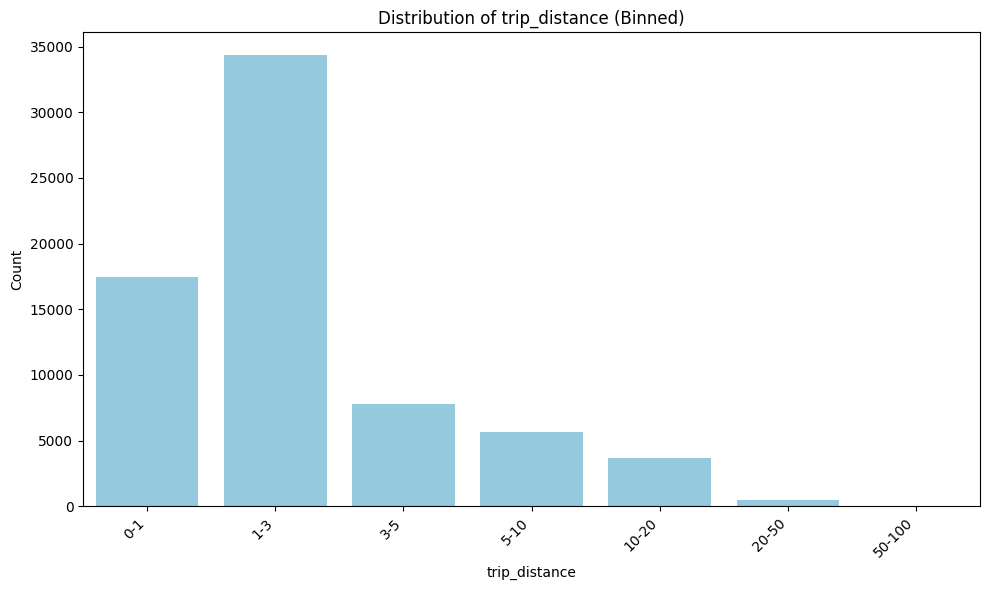


-> Generating Histogram for fare_amount:


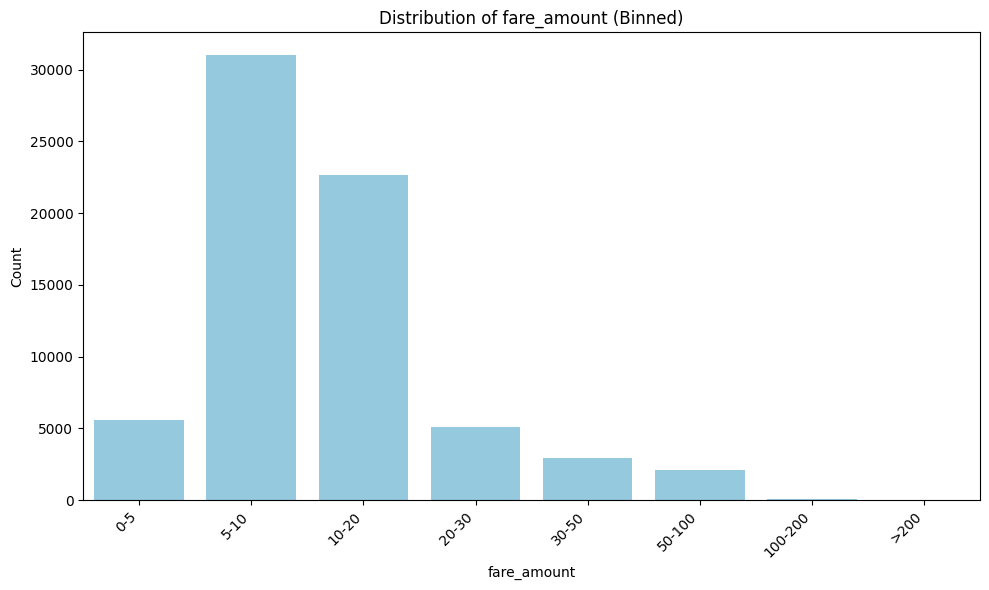


-> Generating Histogram for trip_duration_min:


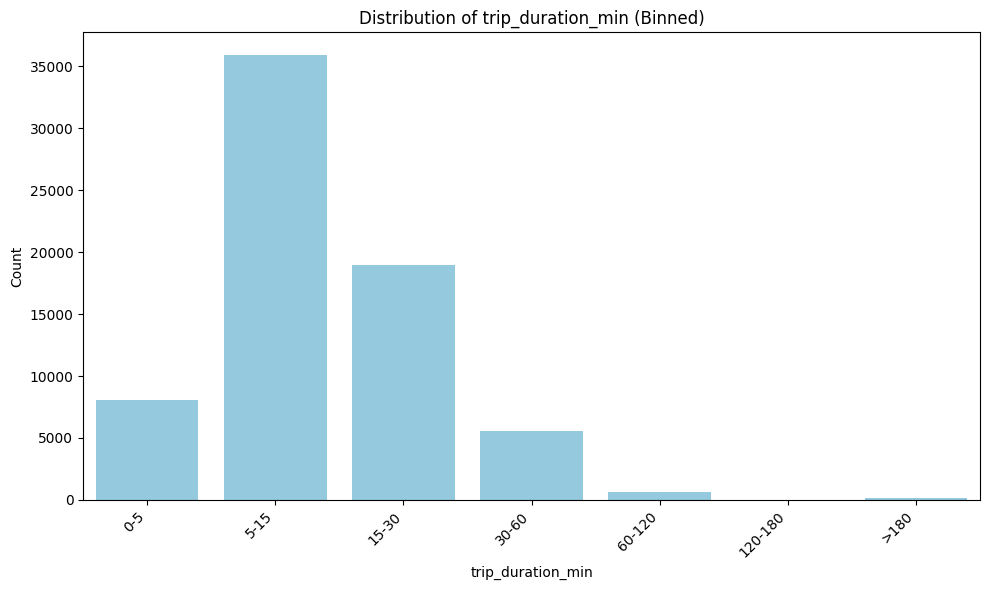

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
histogram_bins = {
    "trip_distance": [float('-inf'), 0, 1, 3, 5, 10, 20, 50, 100, 200, float('inf')],
    "fare_amount": [float('-inf'), 0, 5, 10, 20, 30, 50, 100, 200, float('inf')],
    "trip_duration_min": [float('-inf'), 0, 5, 15, 30, 60, 120, 180, float('inf')]
}

for col_name, splits in histogram_bins.items():
    print(f"\n-> Generating Histogram for {col_name}:")

    bucketizer = Bucketizer(splits=splits, inputCol=col_name, outputCol=f"{col_name}_bin")
    bucketed_df = bucketizer.setHandleInvalid("keep").transform(trip_df)

    # Collect data for plotting - Be cautious with large datasets
    # This converts the Spark DataFrame to a pandas DataFrame in memory
    histogram_data = bucketed_df.groupBy(f"{col_name}_bin").count().orderBy(f"{col_name}_bin").toPandas()

    # Map bin indices to meaningful labels (optional but helpful for x-axis)
    # You might need to adjust the labels based on your splits
    bin_labels = []
    for i in range(len(splits) - 1):
        if i == 0:
            label = f"<{splits[i+1]}"
        elif i == len(splits) - 2:
            label = f">{splits[i]}"
        else:
            label = f"{splits[i]}-{splits[i+1]}"
        bin_labels.append(label)

    # Add labels to the pandas DataFrame
    histogram_data['bin_label'] = histogram_data[f"{col_name}_bin"].apply(lambda x: bin_labels[int(x)] if x is not None and x < len(bin_labels) else 'Invalid/Other')

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='bin_label', y='count', data=histogram_data, color='skyblue')
    plt.title(f'Distribution of {col_name} (Binned)')
    plt.xlabel(col_name)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

Categorical Data


-> Generating Bar Chart for Payment Type Distribution:


<ipython-input-49-60e6b224e164>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='payment_type', y='count', data=payment_type_counts, palette='viridis')


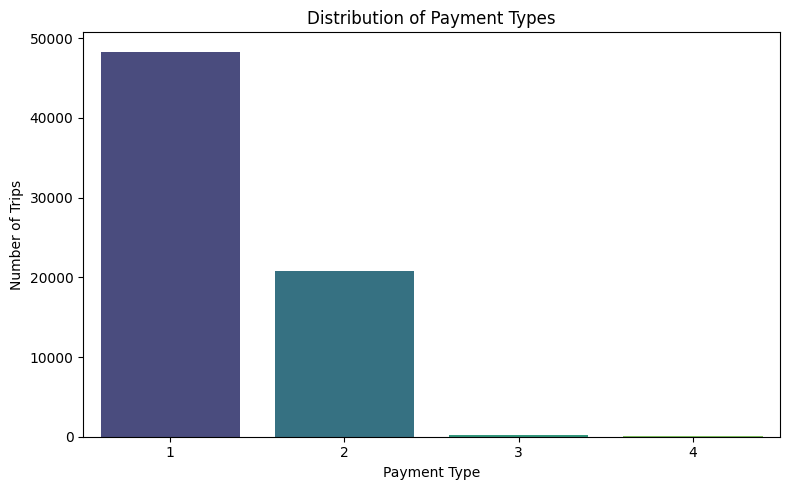


-> Generating Bar Chart for Passenger Count Distribution:


<ipython-input-49-60e6b224e164>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='passenger_count', y='count', data=passenger_count_counts, palette='viridis')


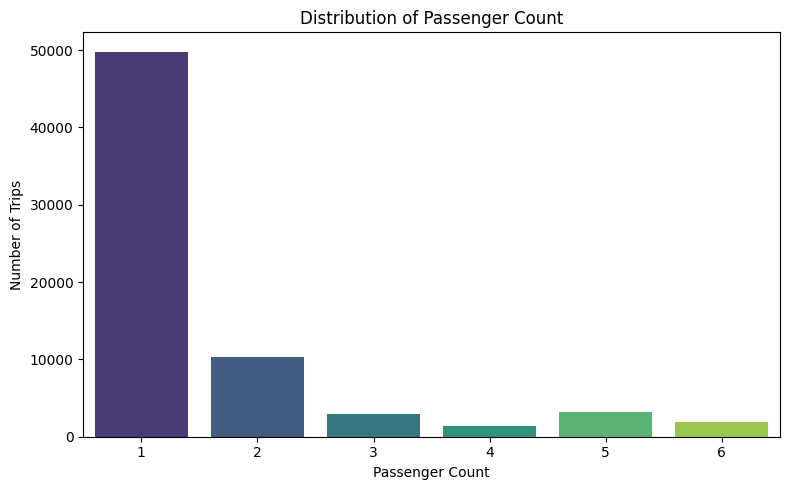

In [ ]:
# Payment Type Distribution (Bar Chart)
print("\n-> Generating Bar Chart for Payment Type Distribution:")

# Get the counts for each payment type
payment_type_counts = trip_df.groupBy("payment_type").count().orderBy("payment_type").toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='payment_type', y='count', data=payment_type_counts, palette='viridis')
plt.title('Distribution of Payment Types')
plt.xlabel('Payment Type')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0) # Keep labels horizontal
plt.tight_layout()
plt.show()

# Passenger Count Distribution (Bar Chart)
print("\n-> Generating Bar Chart for Passenger Count Distribution:")

# Get the counts for each passenger count
passenger_count_counts = trip_df.groupBy("passenger_count").count().orderBy("passenger_count").toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x='passenger_count', y='count', data=passenger_count_counts, palette='viridis')
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0) # Keep labels horizontal
plt.tight_layout()
plt.show()

Correlations and Relationships

In [ ]:
# Time vs Distance (Speed)
print("\n-> Average Speed (MPH):")
trip_df.withColumn("mph", col("trip_distance") / (col("trip_duration_min") / 60)) \
    .select(
        mean("mph").alias("avg_speed"),
        min("mph").alias("min_speed"),
        max("mph").alias("max_speed")
    ).show()

unreasonable_speeds_count = trip_df.withColumn('mph', col('trip_distance') / (col('trip_duration_min') / 60)) \
    .filter((col('mph') < 1) | (col('mph') > 80)) \
    .count()
print(f"\n-> Unreasonable Speeds (<1 or >80 mph):\nCount: {unreasonable_speeds_count}")


-> Average Speed (MPH):
+------------------+--------------------+---------+
|         avg_speed|           min_speed|max_speed|
+------------------+--------------------+---------+
|11.368044095322624|0.023255813953488375|   2532.0|
+------------------+--------------------+---------+


-> Unreasonable Speeds (<1 or >80 mph):
Count: 204


In [ ]:
# Tip percent
print("\n-> Tip Percentage of Fare:")
trip_df.withColumn("tip_pct", col("tip_amount") / col("fare_amount") * 100) \
    .select(
        mean("tip_pct").alias("avg_tip_pct"),
        min("tip_pct").alias("min_tip_pct"),
        max("tip_pct").alias("max_tip_pct")
    ).show()


-> Tip Percentage of Fare:
+------------------+-----------+----------------+
|       avg_tip_pct|min_tip_pct|     max_tip_pct|
+------------------+-----------+----------------+
|14.759587422618498|        0.0|531.578947368421|
+------------------+-----------+----------------+



Merge Completeness

In [ ]:
print("\n-> Join Completeness Check:")
print(f"Records with pickup zone: {trip_df.filter(col('pickup_zone').isNotNull()).count()}")
print(f"Records with dropoff zone: {trip_df.filter(col('dropoff_zone').isNotNull()).count()}")

print("\n-> Sample of Joined Pickup/Dropoff Zones:")
trip_df.select(
    "pickup_location_id", "pickup_zone", "pickup_borough",
    "dropoff_location_id", "dropoff_zone", "dropoff_borough"
).sample(0.01).show(10, truncate=False)


-> Join Completeness Check:
Records with pickup zone: 68336
Records with dropoff zone: 68319

-> Sample of Joined Pickup/Dropoff Zones:
+------------------+------------------------------+--------------+-------------------+---------------------+---------------+
|pickup_location_id|pickup_zone                   |pickup_borough|dropoff_location_id|dropoff_zone         |dropoff_borough|
+------------------+------------------------------+--------------+-------------------+---------------------+---------------+
|144               |Little Italy/NoLiTa           |Manhattan     |249                |West Village         |Manhattan      |
|138               |LaGuardia Airport             |Queens        |170                |Murray Hill          |Manhattan      |
|263               |Yorkville West                |Manhattan     |137                |Kips Bay             |Manhattan      |
|236               |Upper East Side North         |Manhattan     |237                |Upper East Side South|Manha

Column Check

In [ ]:
def column_profile(df, col_name):
    return df.select(
        count(col_name).alias("count"),
        mean(col_name).alias("mean"),
        stddev(col_name).alias("stddev"),
        min(col_name).alias("min"),
        percentile_approx(col_name, 0.25).alias("p25"),
        percentile_approx(col_name, 0.5).alias("median"),
        percentile_approx(col_name, 0.75).alias("p75"),
        max(col_name).alias("max")
    ).withColumn("column", lit(col_name))

In [ ]:
numeric_cols = [f.name for f in trip_df.schema.fields if isinstance(f.dataType, (IntegerType, DoubleType, FloatType))]
profiles = [column_profile(trip_df, col) for col in numeric_cols]
print("\n-> Numeric Columns Summary Statistics:")
reduce(lambda x, y: x.union(y), profiles).show(truncate=False)


-> Numeric Columns Summary Statistics:
+-----+-------------------+--------------------+----+-----+------+-----+------+-------------------+
|count|mean               |stddev              |min |p25  |median|p75  |max   |column             |
+-----+-------------------+--------------------+----+-----+------+-----+------+-------------------+
|69392|1.5952559372838369 |0.5142457375308046  |1.0 |1.0  |2.0   |2.0  |4.0   |vendor_id          |
|69392|1.6090327415264007 |1.2360157701426473  |1.0 |1.0  |1.0   |2.0  |6.0   |passenger_count    |
|69392|2.943243601567896  |3.7849099868286595  |0.01|0.99 |1.62  |3.0  |84.38 |trip_distance      |
|69392|1.0355948812543232 |0.25358124772555485 |1.0 |1.0  |1.0   |1.0  |5.0   |rate_code          |
|69392|1.308882868342172  |0.4754406267240588  |1.0 |1.0  |1.0   |2.0  |4.0   |payment_type       |
|69392|12.89608528360618  |11.195499973804727  |0.01|6.5  |9.5   |14.5 |326.0 |fare_amount        |
|69392|0.33247103412497114|0.46696164074179003 |0.0 |0.0  |0

In [ ]:
categorical_cols = [f.name for f in trip_df.schema.fields if isinstance(f.dataType, StringType)]
for col_name in categorical_cols:
    print(f"\n-> Top 5 Values for Categorical Column: {col_name}")
    trip_df.groupBy(col_name).count().orderBy("count", ascending=False).show(5, truncate=False)



-> Top 5 Values for Categorical Column: pickup_datetime
+---------------+-----+
|pickup_datetime|count|
+---------------+-----+
|3/23/2018 17:56|5    |
|3/20/2018 17:11|5    |
|3/3/2018 12:03 |4    |
|11/8/2018 22:38|4    |
|4/18/2018 20:17|4    |
+---------------+-----+
only showing top 5 rows


-> Top 5 Values for Categorical Column: dropoff_datetime
+----------------+-----+
|dropoff_datetime|count|
+----------------+-----+
|3/10/2018 11:04 |5    |
|3/3/2018 15:30  |4    |
|3/31/2018 19:07 |4    |
|11/8/2018 23:05 |4    |
|10/16/2018 19:54|4    |
+----------------+-----+
only showing top 5 rows


-> Top 5 Values for Categorical Column: pickup_zone
+----------------------------+-----+
|pickup_zone                 |count|
+----------------------------+-----+
|Upper East Side South       |2872 |
|Midtown Center              |2589 |
|Upper East Side North       |2551 |
|Penn Station/Madison Sq West|2398 |
|Midtown East                |2381 |
+----------------------------+-----+
only sho

## Final Cleaning

In [ ]:
from pyspark.sql import functions as F

def clean_taxi_data_spark(df):
    # Drop rows where both pickup and dropoff location ids are null
    df = df.filter(~(F.col('pickup_location_id').isNull() & F.col('dropoff_location_id').isNull()))

    # Fill missing zone and borough names — keep IDs as they are
    df = df.fillna({
        'pickup_zone': 'Unknown (Unmatched ID)',
        'dropoff_zone': 'Unknown (Unmatched ID)',
        'pickup_borough': 'Unknown (Unmatched ID)',
        'dropoff_borough': 'Unknown (Unmatched ID)'
    })

    # Remove trips with zero or negative trip duration
    if 'trip_duration_min' in df.columns:
        df = df.filter(F.col('trip_duration_min') > 0)

    # Clip negative monetary and distance columns to zero
    monetary_cols = ['fare_amount', 'tip_amount', 'computed_total_cost']
    distance_cols = ['trip_distance']

    for col in monetary_cols + distance_cols:
        if col in df.columns:
            df = df.withColumn(col, F.when(F.col(col) < 0, 0).otherwise(F.col(col)))

    # Remove outliers using IQR method (1.5 * IQR)
    numeric_cols = [f.name for f in df.schema.fields if str(f.dataType) in ['IntegerType', 'DoubleType', 'FloatType', 'LongType', 'DecimalType']]

    for col in numeric_cols:
        quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        if len(quantiles) == 2:
            Q1, Q3 = quantiles
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df = df.filter((F.col(col) >= lower_bound) & (F.col(col) <= upper_bound))

    # Sanity check: positive speed only, cap at 80 mph
    if 'speed_mph' in df.columns:
        df = df.filter(F.col('speed_mph') > 0)
        df = df.withColumn('speed_mph', F.when(F.col('speed_mph') > 80, 80).otherwise(F.col('speed_mph')))

    # Tip % sanity check: tip_amount / fare_amount ∈ [0, 1]
    if 'tip_amount' in df.columns and 'fare_amount' in df.columns:
        df = df.withColumn('tip_pct', F.when(F.col('fare_amount') == 0, None).otherwise(F.col('tip_amount') / F.col('fare_amount')))
        df = df.filter((F.col('tip_pct') >= 0) & (F.col('tip_pct') <= 1))

    # Fare per mile sanity check: <= 50
    if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        df = df.withColumn('fare_per_mile', F.when(F.col('trip_distance') == 0, None).otherwise(F.col('fare_amount') / F.col('trip_distance')))
        df = df.filter((F.col('fare_per_mile') <= 50) | (F.col('fare_per_mile').isNull()))

    # Show summary statistics
    print("Basic summary stats:")
    df.describe().show()

    # Show missing values per column
    print("Missing values per column:")
    df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

    # Save cleaned data to CSV
    df.write.mode('overwrite').option('header', True).csv('cleaned_taxi_data_spark.csv')

    return df


In [ ]:
cleaned_df = clean_taxi_data_spark(trip_df)

Basic summary stats:
+-------+------------------+---------------+----------------+------------------+------------------+-------------------+------------------+------------------+-------------------+--------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+--------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|summary|         vendor_id|pickup_datetime|dropoff_datetime|   passenger_count|     trip_distance|          rate_code|      payment_type|       fare_amount|              extra|             mta_tax|        tip_amount|       tolls_amount|       imp_surcharge|pickup_location_id|dropoff_location_id| trip_duration_min|computed_total_cost|   pickup_zone|      pickup_borough|        dropoff_zone|     dropoff_borough|            tip_pct|       fare_per_mile|
+-------+------------------+---------------+----------------+------

In [ ]:
cleaned_df.show()

+---------+----------------+----------------+---------------+-------------+---------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+-----------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|vendor_id| pickup_datetime|dropoff_datetime|passenger_count|trip_distance|rate_code|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|imp_surcharge|pickup_location_id|dropoff_location_id|trip_duration_min|computed_total_cost|         pickup_zone|      pickup_borough|        dropoff_zone|     dropoff_borough|             tip_pct|     fare_per_mile|
+---------+----------------+----------------+---------------+-------------+---------+------------+-----------+-----+-------+----------+------------+-------------+------------------+-------------------+-----------------+-------------------+--------------------+------------

# Analytical Queries

## What is the most common payment type used per time of day (morning, afternoon, evening)?

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window # Import the Window class

df=cleaned_df
# define time of day categories based on pickup_datetime hour
df = df.withColumn('hour', F.hour(F.to_timestamp('pickup_datetime', 'M/d/yyyy H:mm')))

df = df.withColumn('time_of_day',
                   F.when((F.col('hour') >= 5) & (F.col('hour') < 12), 'morning')
                    .when((F.col('hour') >= 12) & (F.col('hour') < 17), 'afternoon')
                    .when((F.col('hour') >= 17) & (F.col('hour') <= 21), 'evening')
                    .otherwise('night'))

# Find the most common payment_type per time_of_day
payment_mode_per_time = df.groupBy('time_of_day', 'payment_type') \
                          .count() \
                          .withColumn('rank', F.row_number().over(
                              Window.partitionBy('time_of_day').orderBy(F.desc('count'))
                          )) \
                          .filter(F.col('rank') == 1) \
                          .select('time_of_day', 'payment_type', 'count')

payment_mode_per_time.show()

+-----------+------------+-----+
|time_of_day|payment_type|count|
+-----------+------------+-----+
|  afternoon|           1|12097|
|    evening|           1|14652|
|    morning|           1|12578|
|      night|           1| 8943|
+-----------+------------+-----+



## Which boroughs generate the highest total revenue based on pickup locations, and how do they compare in terms of trip volume?

In [ ]:
borough_revenue_volume = df.filter(F.col('pickup_borough') != 'Unknown (Unmatched ID)') \
                           .groupBy('pickup_borough') \
                           .agg(
                               F.sum('fare_amount').alias('total_revenue'),
                               F.count('*').alias('trip_volume')
                           ) \
                           .orderBy(F.desc('total_revenue'))

borough_revenue_volume.show()

+--------------+------------------+-----------+
|pickup_borough|     total_revenue|trip_volume|
+--------------+------------------+-----------+
|     Manhattan| 707283.3600000001|      62951|
|        Queens|155537.84999999998|       4328|
|      Brooklyn|          13191.89|        872|
|         Bronx|           1863.74|         78|
+--------------+------------------+-----------+



## What is the average tip amount per passenger count?

In [ ]:
avg_tip_per_passenger = df.groupBy('passenger_count') \
                          .agg(F.avg('tip_amount').alias('avg_tip_amount')) \
                          .orderBy('passenger_count')

avg_tip_per_passenger.show()


+---------------+------------------+
|passenger_count|    avg_tip_amount|
+---------------+------------------+
|              1| 1.854670407014162|
|              2|  1.84910281469898|
|              3|1.7760646057658906|
|              4|1.6726237623762388|
|              5|1.8401287688442214|
|              6|1.9345119305856822|
+---------------+------------------+



## What are the best 5 locations for drivers to pick up passengers from and at which time of the day?

In [ ]:
# Count trips by pickup_zone and time_of_day
pickup_zone_time_counts = df.groupBy('pickup_zone', 'time_of_day') \
                           .count() \
                           .orderBy(F.desc('count'))

# Find top 5 pickup_zone + time_of_day combos by trip count
top_5_pickup_locations = pickup_zone_time_counts.limit(5)
top_5_pickup_locations.show()


+--------------------+-----------+-----+
|         pickup_zone|time_of_day|count|
+--------------------+-----------+-----+
|Upper East Side S...|  afternoon|  962|
|Upper East Side N...|  afternoon|  905|
|        Midtown East|    evening|  849|
|Upper East Side S...|    evening|  847|
|      Midtown Center|    evening|  832|
+--------------------+-----------+-----+



## What are the top 5 longest trips recorded in the dataset and display their corresponding trip  duration, fare, pickup and dropoff zones, and payment type. Comment on whether these trips also resulted in high fares or if any anomalies are observed.

In [ ]:
top_5_longest_trips = df.select('trip_duration_min', 'fare_amount', 'pickup_zone', 'dropoff_zone', 'payment_type') \
                        .orderBy(F.desc('trip_duration_min')) \
                        .limit(5)

top_5_longest_trips.show()

+-----------------+-----------+--------------------+--------------------+------------+
|trip_duration_min|fare_amount|         pickup_zone|        dropoff_zone|payment_type|
+-----------------+-----------+--------------------+--------------------+------------+
|           1440.0|       12.0|            Gramercy|     Lower East Side|           1|
|           1440.0|        6.5|      Yorkville West|Upper West Side S...|           2|
|           1439.0|        8.5|Penn Station/Madi...|Stuy Town/Peter C...|           1|
|           1439.0|       10.0|Unknown (Unmatche...|Unknown (Unmatche...|           1|
|           1439.0|       19.0|         Murray Hill|Williamsburg (Sou...|           2|
+-----------------+-----------+--------------------+--------------------+------------+



In [ ]:
top_5_longest_trips = df.select('trip_duration_min', 'fare_amount', 'pickup_zone', 'dropoff_zone', 'payment_type') \
                        .orderBy(F.desc('trip_duration_min')) \
                        .limit(5)

top_5_longest_trips.show()

+-----------------+-----------+--------------------+--------------------+------------+
|trip_duration_min|fare_amount|         pickup_zone|        dropoff_zone|payment_type|
+-----------------+-----------+--------------------+--------------------+------------+
|           1440.0|       12.0|            Gramercy|     Lower East Side|           1|
|           1440.0|        6.5|      Yorkville West|Upper West Side S...|           2|
|           1439.0|        8.5|Penn Station/Madi...|Stuy Town/Peter C...|           1|
|           1439.0|       10.0|Unknown (Unmatche...|Unknown (Unmatche...|           1|
|           1439.0|       19.0|         Murray Hill|Williamsburg (Sou...|           2|
+-----------------+-----------+--------------------+--------------------+------------+



## which pickup and drop-off borough combinations represent the most frequent inter-borough travel flows? Present the top routes by trip count, and optionally include revenue per route.

In [ ]:
routes = df.filter(
    (F.col('pickup_borough') != 'Unknown (Unmatched ID)') &
    (F.col('dropoff_borough') != 'Unknown (Unmatched ID)') &
    (F.col('dropoff_borough') != F.col('pickup_borough'))
) \
.groupBy('pickup_borough', 'dropoff_borough') \
.agg(
    F.count('*').alias('trip_count'),
    F.sum('fare_amount').alias('total_revenue')
) \
.orderBy(F.desc('trip_count'))

routes.show(10)

+--------------+---------------+----------+------------------+
|pickup_borough|dropoff_borough|trip_count|     total_revenue|
+--------------+---------------+----------+------------------+
|        Queens|      Manhattan|      2536|100647.06999999999|
|     Manhattan|         Queens|      2111| 68931.68000000001|
|     Manhattan|       Brooklyn|      1832|          42364.95|
|        Queens|       Brooklyn|       598|23702.870000000003|
|     Manhattan|          Bronx|       311| 8635.099999999999|
|      Brooklyn|      Manhattan|       264|           5396.84|
|     Manhattan|            EWR|       118|            8390.0|
|        Queens|          Bronx|        78|            3467.0|
|      Brooklyn|         Queens|        42|           1320.35|
|         Bronx|      Manhattan|        41|           1025.74|
+--------------+---------------+----------+------------------+
only showing top 10 rows



# SparkML Task: Trip Profiling: Predict Likelihood of High Tipping

## Preparing Data for Model

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import hour
from pyspark.sql.types import DoubleType


# Create the binary target column 'high_tip'
cleaned_df = cleaned_df.withColumn('high_tip',
                   when(col('tip_amount') > 0.15 * col('fare_amount'), 1)
                   .otherwise(0))

In [ ]:
# Select numerical and categorical features
numerical_features = [ 'passenger_count', 'trip_distance', 'rate_code', 'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount', 'trip_duration_min', 'computed_total_cost',  'tip_pct', 'fare_per_mile']
categorical_features = ['pickup_zone',    'pickup_borough',      'dropoff_zone',    'dropoff_borough']


In [ ]:
# Use StringIndexer and OneHotEncoder for categorical features
# HandleInvalid="keep" will keep categories not seen during fitting (e.g., Unknown)
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep") for col in categorical_features]
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getOutputCol()+"_encoded") for indexer in indexers]

In [ ]:
# Create a pipeline to apply indexing and encoding
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

# Assuming indexers, encoders, and final_numeric_features are defined as before

# Identify numerical columns for standardization
cols_to_standardize = numerical_features

# Create a VectorAssembler for the numerical columns *before* standardization
# This is needed because StandardScaler expects a vector input
assembler_for_scaling = VectorAssembler(inputCols=cols_to_standardize, outputCol="numerical_features_vector", handleInvalid="skip")

# Create the StandardScaler
scaler = StandardScaler(inputCol="numerical_features_vector", outputCol="scaled_numerical_features", withStd=True, withMean=True)

# Create a new VectorAssembler to combine the encoded categorical features and scaled numerical features
# The output column from the OneHotEncoders will be col_indexed_encoded for each categorical col
encoded_categorical_output_cols = [col + "_indexed_encoded" for col in categorical_features]

# This assembler will take the output of the encoders and the scaler
final_assembler_inputs = encoded_categorical_output_cols + ["scaled_numerical_features"]
final_assembler = VectorAssembler(inputCols=final_assembler_inputs, outputCol="features", handleInvalid="skip") # The final feature vector will be named "features"

# Create the new pipeline with all steps: Indexing -> Encoding -> Assemble Numerical -> Scale Numerical -> Final Assemble
full_pipeline = Pipeline(stages=indexers + encoders + [assembler_for_scaling, scaler, final_assembler])

# Fit and transform the data using the full pipeline
# The result will be a DataFrame with all intermediate columns and the final 'features' vector column
df_transformed = full_pipeline.fit(cleaned_df).transform(cleaned_df)

# Select only the final feature vector column and the target variable ('high_tip')
final_df = df_transformed.select("features", "high_tip")

# Show the resulting DataFrame with only the feature vector and target
final_df.show(5)

+--------------------+--------+
|            features|high_tip|
+--------------------+--------+
|(454,[27,195,271,...|       1|
|(454,[8,195,204,4...|       1|
|(454,[20,195,229,...|       0|
|(454,[14,195,208,...|       1|
|(454,[42,195,289,...|       1|
+--------------------+--------+
only showing top 5 rows



## Train Test Split

In [ ]:
train_data = final_df.randomSplit([0.8, 0.2], seed=42)
train_df = train_data[0]
test_df = train_data[1]

## Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

logistic_regressor = LogisticRegression(featuresCol="features", labelCol="high_tip", maxIter=10)
logistic_model = logistic_regressor.fit(train_df)

## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="high_tip", maxDepth=5)
dt_model = dt_classifier.fit(train_df)

## Random Forests

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="high_tip", numTrees=10)
rf_model = rf_classifier.fit(train_df)

# Model Evaluation and Our Findings

We found that Decision Trees worked best for our data. This is likely because our data had many clear/rule based-patterns, like the definiton of a high tip as well as many categorical and discrete features (passenger data, location data etc), we also believe there may have been some non-linear relationships in the data which could have led to the increased performance of the Decision Tree. Finally it's overall a small dataset, so it makes sense for all 3 models to have close results.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions on the test data for each model
logistic_predictions = logistic_model.transform(test_df)
dt_predictions = dt_model.transform(test_df)
rf_predictions = rf_model.transform(test_df)

# Evaluate each model using BinaryClassificationEvaluator (using AUC)
evaluator = BinaryClassificationEvaluator(labelCol="high_tip", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

logistic_accuracy = evaluator.evaluate(logistic_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)

# Print the accuracies
print(f"Logistic Regression Accuracy (AUC): {logistic_accuracy:.4f}")
print(f"Decision Tree Accuracy (AUC): {dt_accuracy:.4f}")
print(f"Random Forest Accuracy (AUC): {rf_accuracy:.4f}")

# You can also compare other metrics like F1 score, precision, recall if needed
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

multi_evaluator = MulticlassClassificationEvaluator(labelCol="high_tip", predictionCol="prediction", metricName="f1")

logistic_f1 = multi_evaluator.evaluate(logistic_predictions)
dt_f1 = multi_evaluator.evaluate(dt_predictions)
rf_f1 = multi_evaluator.evaluate(rf_predictions)

print(f"\nLogistic Regression F1 Score: {logistic_f1:.4f}")
print(f"Decision Tree F1 Score: {dt_f1:.4f}")
print(f"Random Forest F1 Score: {rf_f1:.4f}")


Logistic Regression Accuracy (AUC): 0.9997
Decision Tree Accuracy (AUC): 0.9999
Random Forest Accuracy (AUC): 0.9936

Logistic Regression F1 Score: 0.9959
Decision Tree F1 Score: 0.9977
Random Forest F1 Score: 0.9113
